<a href="https://colab.research.google.com/github/yhc-666/CS4243CaptchaRecognition/blob/master/recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 设置压缩文件路径和解压目标路径
zip_file_path = '/content/drive/MyDrive/CS4243/data.zip'  # 替换为您的压缩文件路径
extract_to_path = '/content/drive/MyDrive/CS4243/data'

In [ ]:
import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [ ]:
from tqdm import tqdm

### DataPrepare and Augmentation

In [ ]:
class Segmenter:
    def segment_chars(self, img_path: str, plot=False) -> list:
        # 返回的是一个包含分割后字符图像及其标签的列表，每个元素为一个元组 (char_img, label)
        image = cv2.imread(img_path)
        origin = image.copy()
        if plot:
            cv2_imshow(origin)

        # 转换为灰度图像，以便更容易识别黑色区域
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 定义黑色的阈值范围，生成掩码
        lower_black = 0       # 黑色的下限
        upper_black = 10      # 上限（根据图像的黑线深浅调整）
        mask = cv2.inRange(gray, lower_black, upper_black)

        # 定义掩码的卷积核，用于形态学操作
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

        # 通过形态学操作去除噪声并清理边缘
        mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # 使用 inpaint 函数，根据周围的非黑色像素填充黑线区域
        # inpaint 需要三通道图像，因此直接使用 BGR 格式的原始图像
        # 第三个参数为填充半径
        image = cv2.inpaint(image, mask_cleaned, 3, cv2.INPAINT_TELEA)

        if plot:
            cv2_imshow(image)

        img = image
        # 转换为灰度图像
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 使用自适应阈值进行二值化，以适应不同亮度
        thresh = cv2.adaptiveThreshold(
            img_gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            11, 2
        )

        # 使用形态学闭操作清理噪声并填补字符间隙
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # 查找轮廓
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 获取文件名中的字符标签
        labels = [char for char in os.path.basename(img_path).split('-')[0]]

        # 筛选符合字符大小的轮廓，避免噪声
        char_contours = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = h / float(w)
            if 0.2 < aspect_ratio < 10 and 5 < w < 100:  # 依据宽高比和尺寸过滤字符轮廓
                char_contours.append((x, y, w, h))

        # 按水平方向排序，保证字符顺序
        char_contours = sorted(char_contours, key=lambda x: x[0])

        # 如果轮廓数量少于标签数量，用空白图像补全
        segmented_chars = []
        for i, label in enumerate(labels):
            if i < len(char_contours):
                # 获取字符区域
                x, y, w, h = char_contours[i]

                # 略微扩大字符边界框
                x = max(x - 1, 0)
                y = max(y - 1, 0)
                w = min(w + 2, image.shape[1] - x)
                h = min(h + 2, image.shape[0] - y)

                char_img = image[y:y+h, x:x+w]
            else:
                # 填充空白图像
                char_img = np.ones((15, 12, 3), dtype=np.uint8) * 255  # 假设字符大小为 15x12

            segmented_chars.append((char_img, label))

        # 可视化分割结果
        if plot:
            self.plot_segmented_chars(origin, segmented_chars)

        return segmented_chars


    def plot_segmented_chars(self, img, segmented_chars):
        # 动态调整 width_ratios 以适应 segmented_chars 的数量
        width_ratios = [1] * len(segmented_chars)
        fig, axes = plt.subplots(1, len(segmented_chars), figsize=(12, 2), gridspec_kw={'width_ratios': width_ratios})

        # 如果只有一个字符，axes 不是列表，将其包装为列表
        if len(segmented_chars) == 1:
            axes = [axes]

        # 显示每个字符的图像
        for i, (char_img, label) in enumerate(segmented_chars):
            axes[i].imshow(char_img.squeeze(), cmap='gray')
            axes[i].set_title(label)  # 显示字符标签作为标题

        plt.tight_layout()
        plt.show()

In [ ]:
class CaptchaDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]
        self.transform = transform
        self.label_index = {}
        self.seg = Segmenter()
        char_set = 'abcdefghijklmnopqrstuvwxyz0123456789'
        for i in range(len(char_set)):
            self.label_index[char_set[i]] = i

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        获取指定索引处的数据样本，包括验证码图片的分割字符图像和对应的标签索引。

        参数:
        idx (int): 数据集中的索引，用于定位特定图片文件。

        返回:
        tuple:
            - processed_segments (list of torch.Tensor): 包含分割后的字符图像张量列表，
            每个字符图像张量的形状为 `(C, H, W)`，其中 `C` 是通道数（通常为 1），`H` 和 `W` 分别是字符图像的高度和宽度。
            - torch.LongTensor(label_indices): 包含字符标签索引的 1D 张量，形状为 `(num_chars, )`，
            其中 `num_chars` 是该验证码图片中的字符数，与 `processed_segments` 的长度相同。

        例外情况:
        如果分割失败或没有找到字符，返回 None。
        """
        # 获取当前索引处的图片文件路径
        image_path = self.image_paths[idx]

        # 从文件名中提取标签字符，例如对于 "abcd-0.png" 提取 "abcd"
        label = os.path.basename(image_path).split("-")[0]

        # 将标签字符转换为标签索引列表（整数形式）
        # 例如，将 "abcd" 转换为 [0, 1, 2, 3] 这样的索引列表
        label_indices = [self.label_index[l] for l in label]

        # 使用 Segmenter 类对当前图片进行字符分割
        # 返回的 segments 包含了每个字符的图像和对应的标签
        segments = self.seg.segment_chars(image_path)

        # 如果分割失败（没有找到字符），返回 None 表示当前样本无效
        if not segments:
            return

        # 初始化用于存储处理后的字符图像的列表
        processed_segments = []

        # 遍历分割出的字符图像
        for segment in segments:
            # 如果指定了图像变换，则对字符图像进行变换处理
            if self.transform:
                padded_segment = self.transform(Image.fromarray(segment[0]))  # 转换后的 shape 为 (C, H, W)

            # 将处理后的字符图像添加到列表中
            processed_segments.append(padded_segment)

        # 如果处理后的字符图像数量超过了标签数量（可能由于多余的噪声等原因），
        # 则截取至与标签数量一致
        if len(processed_segments) > len(label_indices):
            return processed_segments[:len(label_indices)], torch.LongTensor(label_indices)

        # 否则直接返回字符图像和对应的标签张量
        else:
            return processed_segments, torch.LongTensor(label_indices[:len(processed_segments)])


In [ ]:
def collate_fn(batch):
    """
    用于在批量加载时处理验证码数据集的聚合函数。将批量样本中的字符图像和标签展平成单一张量，确保在不同字符数量时的批处理兼容性。

    参数:
    batch (list): 每个元素都是一个包含字符图像列表和标签张量的元组。
                  例如， [(processed_segments1, labels1), (processed_segments2, labels2), ...]

    返回:
    tuple:
        - padded_images (torch.Tensor): 展平后的字符图像张量，形状为 `(total_chars, C, H, W)`，
          `total_chars` 是所有样本中字符图像的总数量，`C` 是通道数，`H` 和 `W` 是图像高度和宽度。
        - padded_labels (torch.LongTensor): 展平后的标签张量，形状为 `(total_chars, )`，
          包含所有字符图像对应的标签。

    例外情况:
    如果批量中的所有样本都是无效样本 (None)，返回 `(None, None)`。
    """
    # 过滤掉无效样本（None），以确保批处理中不包含空样本
    batch = [item for item in batch if item is not None]
    if not batch:
        return None, None

    # 将所有字符图像和标签分别提取到两个列表中
    batch_images, batch_labels = zip(*batch)

    # 初始化空列表，用于存储展平后的字符图像和标签
    all_images = []
    all_label = []

    # 遍历每个样本的字符图像和标签
    for images in batch_images:
        for image in images:
            all_images.append(image)  # 将每个字符图像添加到展平列表

    for labels in batch_labels:
        for label in labels:
            all_label.append(label)  # 将每个字符的标签添加到展平列表

    # 将字符图像列表转换为张量，并组合为一个批量张量
    # 结果张量形状为 (total_chars, C, H, W)，其中 total_chars 是批量中所有字符的总数
    padded_images = torch.stack(all_images)

    # 将标签列表转换为张量，形成展平的标签张量，形状为 (total_chars, )
    padded_labels = torch.stack(all_label)

    # 返回展平后的字符图像张量和标签张量
    return padded_images, padded_labels


In [ ]:
transform_train = transforms.Compose([
            transforms.Grayscale(), # 3-band to 1-band
            transforms.Resize((30, 24)), # average size of each char image
            transforms.RandomRotation(degrees=(-25, 25)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

In [ ]:
transform_test = transforms.Compose([
            transforms.Grayscale(), # 3-band to 1-band
            transforms.Resize((30, 24)), # average size of each char image
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

### Create DL model

In [ ]:
class ResNetForCaptcha(nn.Module):
    def __init__(self, num_classes):
        super(ResNetForCaptcha, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(512, 64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.model(x)

### train DL model

In [ ]:
# 创建训练集和测试集的 CaptchaDataset 实例
train_dataset = CaptchaDataset(image_dir='/content/drive/MyDrive/CS4243/data/train', transform=transform_train)
test_dataset = CaptchaDataset(image_dir='/content/drive/MyDrive/CS4243/data/test', transform=transform_test)

# 创建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda")
model = ResNetForCaptcha(num_classes=len('abcdefghijklmnopqrstuvwxyz0123456789')).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", ncols=100):
            if batch[0] is None:
                continue
            batch_images, batch_labels = batch
            batch_labels = batch_labels.to(device)

            outputs = model(batch_images.to(device))
            batch_labels = batch_labels.view(-1)
            loss = criterion(outputs, batch_labels[batch_labels != -1])
            running_loss += loss.item()

    return running_loss / len(dataloader)

def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device):
    train_loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        """
        迭代DataLoader：
        当开始遍历 DataLoader（例如 for batch in dataloader）时，DataLoader 会自动分批从 Dataset 中提取数据。
        获取样本：
        对于每一个 batch，DataLoader 会根据 batch_size 的大小，按索引调用 Dataset 的 __getitem__ 方法。
        如果 batch_size=64，DataLoader 就会调用 64 次 __getitem__ 方法来获取 64 个样本的 item，并将这些样本放入一个 batch 中。
        组合成批次：
        调用 __getitem__ 得到的 64 个样本会被 DataLoader 组合在一起，通常是通过 collate_fn 方法（默认为 default_collate）来合并。
        组合后的 batch 是一个包含 batch_size 个样本的数据块，通常是一个包含图像张量和标签张量的元组，形状为 (batch_size, C, H, W)（图像）和 (batch_size,)（标签）。

        """

        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', ncols=100):
            if batch[0] is None:
                continue
            batch_images, batch_labels = batch
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()

            outputs = model(batch_images.to(device))
            batch_labels = batch_labels.view(-1)
            loss = criterion(outputs, batch_labels[batch_labels != -1])

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 计算并记录训练集和测试集的平均损失
        train_epoch_loss = running_loss / len(train_dataloader)
        test_epoch_loss = evaluate(model, test_dataloader, criterion, device)

        train_loss_history.append(train_epoch_loss)
        test_loss_history.append(test_epoch_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Test Loss: {test_epoch_loss:.4f}')

    # 返回训练和测试损失的历史数据
    return train_loss_history, test_loss_history

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [08:00<00:00, 20.03s/it]


Epoch [1/20], Train Loss: 3.3874, Test Loss: 3.0018


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:15<00:00,  1.57it/s]


Epoch [2/20], Train Loss: 2.4792, Test Loss: 1.9442


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


Epoch [3/20], Train Loss: 1.8625, Test Loss: 1.5609


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.61it/s]


Epoch [4/20], Train Loss: 1.6027, Test Loss: 1.3975


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.61it/s]


Epoch [5/20], Train Loss: 1.4616, Test Loss: 1.3191


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.64it/s]


Epoch [6/20], Train Loss: 1.3653, Test Loss: 1.2464


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


Epoch [7/20], Train Loss: 1.2880, Test Loss: 1.2027


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


Epoch [8/20], Train Loss: 1.2357, Test Loss: 1.1671


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.65it/s]


Epoch [9/20], Train Loss: 1.1799, Test Loss: 1.1360


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:15<00:00,  1.57it/s]


Epoch [10/20], Train Loss: 1.1375, Test Loss: 1.1215


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.65it/s]


Epoch [11/20], Train Loss: 1.0955, Test Loss: 1.1186


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


Epoch [12/20], Train Loss: 1.0654, Test Loss: 1.0994


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.64it/s]


Epoch [13/20], Train Loss: 1.0249, Test Loss: 1.0993


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.65it/s]


Epoch [14/20], Train Loss: 0.9964, Test Loss: 1.0851


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.62it/s]


Epoch [15/20], Train Loss: 0.9651, Test Loss: 1.0899


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


Epoch [16/20], Train Loss: 0.9333, Test Loss: 1.0824


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.62it/s]


Epoch [17/20], Train Loss: 0.8967, Test Loss: 1.0788


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


Epoch [18/20], Train Loss: 0.8761, Test Loss: 1.0768


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.63it/s]


Epoch [19/20], Train Loss: 0.8492, Test Loss: 1.0775


Evaluating: 100%|███████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.67it/s]


Epoch [20/20], Train Loss: 0.8238, Test Loss: 1.0869


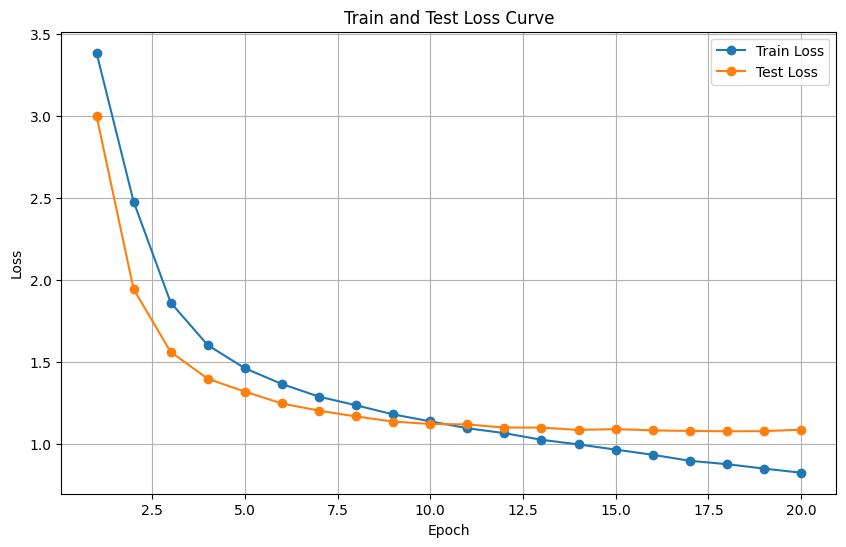

In [ ]:
# 调用训练函数并获取损失历史数据
train_loss_history, test_loss_history = train_model(
    model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=20, device=device
)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, marker='o', label='Train Loss')
plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CS4243/model/resnet_captcha_model_v3.pth')

### Evaluating on train set

In [ ]:
train_dataset = CaptchaDataset(image_dir='/content/drive/MyDrive/CS4243/data/train', transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [ ]:
model.eval()
total = 0
correct = 0
for batch in tqdm(train_dataloader, desc="Evaluation Progress on train set", ncols=100):
    if batch[0] is None:
        continue
    batch_images, batch_labels = batch

    # 将输入数据和标签发送到 GPU 或 CPU 上
    outputs = model(batch_images.to(device))

    # 获取每个样本的预测类别
    predictions = torch.argmax(outputs, dim=1).cpu()

    # 计算正确预测的数量
    correct_predictions = (predictions == batch_labels).sum().item()
    correct += correct_predictions
    total += len(outputs)

#"signle segments acc:"
print(correct / total)

Evaluation Progress on train set: 100%|███████████████████████████| 100/100 [02:15<00:00,  1.35s/it]

0.8035570137749655


### Evaluating on test set

In [ ]:
test_dataset = CaptchaDataset(image_dir='/content/drive/MyDrive/CS4243/data/test', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
model.eval()
total = 0
correct = 0
for batch in tqdm(test_dataloader, desc="Evaluation Progress on test set", ncols=100):
    if batch[0] is None:
        continue
    batch_images, batch_labels = batch

    # 将输入数据和标签发送到 GPU 或 CPU 上
    outputs = model(batch_images.to(device))

    # 获取每个样本的预测类别
    predictions = torch.argmax(outputs, dim=1).cpu()

    # 计算正确预测的数量
    correct_predictions = (predictions == batch_labels).sum().item()
    correct += correct_predictions
    total += len(outputs)

#"signle segments acc:"
print(correct / total)

Evaluation Progress on test set: 100%|██████████████████████████████| 24/24 [00:14<00:00,  1.61it/s]

0.7532188841201717


### Prediction with our model

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 初始化反向映射，方便从索引转换回字符
index_label = {v: k for k, v in test_dataset.label_index.items()}  # 例如，{0: 'a', 1: 'b', ...}

def predict_captcha(model, image_path, segmenter, transform, device):
    # 使用 Segmenter 分割字符
    segments = segmenter.segment_chars(image_path, plot=True)

    # 如果分割失败，返回 None
    if not segments:
        return None

    predicted_string = ""
    model.eval()  # 切换模型到评估模式

    fig, axes = plt.subplots(1, len(segments), figsize=(2 * len(segments), 2))

    with torch.no_grad():  # 禁用梯度计算，以提高推理速度和节省内存
        # 遍历分割出的字符图像
        for i, segment in enumerate(segments):
            # 转换 numpy 数组为 PIL 图像，然后应用 transform
            char_img = Image.fromarray(segment[0])
            padded_segment = transform_test(char_img)

            # 将 Tensor 图像添加 batch 维度并移动到 GPU
            char_img_tensor = padded_segment.unsqueeze(0).to(device)

            # 模型预测
            output = model(char_img_tensor)
            _, predicted_index = output.max(1)  # 获取预测的类别索引

            # 将类别索引转换回字符
            predicted_char = index_label[predicted_index.item()]
            predicted_string += predicted_char

            # 显示转换后的图像和标签
            axes[i].imshow(padded_segment.permute(1, 2, 0).cpu().numpy(), cmap='gray')


    plt.show()
    return predicted_string


In [ ]:
segmenter = Segmenter()

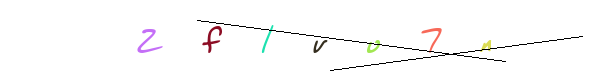

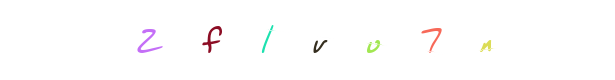

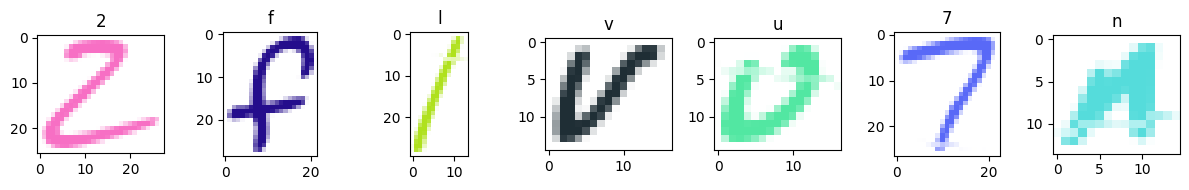

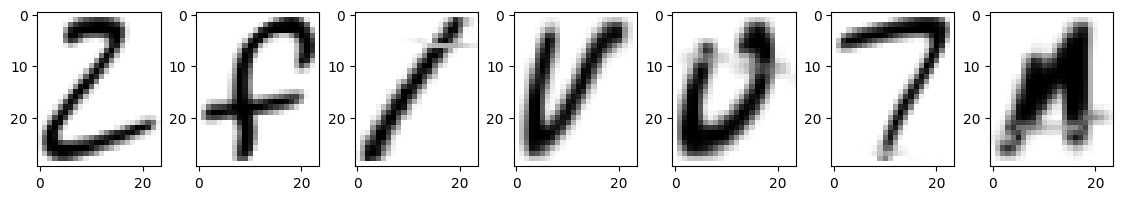

'2flvu7m'

In [ ]:
predict_captcha(model, '/content/drive/MyDrive/CS4243/data/test/2flvu7n-0.png', segmenter, transform_test, device)

## 测试segmentation